<a href="https://colab.research.google.com/github/LKSfiuza/Deeplearning/blob/main/ELT_575_Semana_3_118678_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from pandas import read_csv
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt

# Importando dados

Nesse problema de predição, usaremos o dataset tesla_stock_2015_2022. Assim, usamos a função read_csv do pandas passando uma URL como caminho dos dados.
* Usaremos os últimos 20% dos pontos temporais como dados de teste

* Uma transformação Min-Max é usada apenas para colocar os dados numa escala [0,1]

In [3]:
def get_train_test(url, split_percent=0.8):
    df = read_csv(url, usecols=["Open"], engine='python')
    data = np.array(df.values.astype('float32'))
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data).flatten()
    n = len(data)
    # Point for splitting data into train and test
    split = int(n*split_percent)
    train_data = data[range(split)]
    test_data = data[split:]
    return train_data, test_data, data

sunspots_url = '/content/tesla_stock_2015_2022 (1).csv'
train_data, test_data, data = get_train_test(sunspots_url)

# Preparação dos dados

Para preparar os dados para a rede recorrente, devemos quebrar a série temporal em vetores de tamanho igual ao número de entradas da nossa rede (estamos considerando assim quantos time steps passados estamos usando para prever o time step atual)

In [4]:
len(train_data)

1315

In [5]:
# Prepare the input X and target Y
def get_XY(dat, time_steps):
    # Indices of target array
    Y_ind = np.arange(time_steps, len(dat), time_steps)
    Y = dat[Y_ind]
    # Prepare X
    rows_x = len(Y)
    X = dat[range(time_steps*rows_x)]
    X = np.reshape(X, (rows_x, time_steps, 1))
    return X, Y

time_steps = 12
trainX, trainY = get_XY(train_data, time_steps)
testX, testY = get_XY(test_data, time_steps)

# Construindo o modelo

Para a primeira modificação da atividade usaremos aqui uma rede recorrente simples com 50 unidades ocultas que utilizam 12 passos anteriores para estimar o atual estado. O resultado é avaliado por um único neurônio totalmente conectado que nos dá a saída da rede
* Função de ativação tanh em ambas as camadas da rede.

* Como função objetiva, usaremos o erro médio quadrático, já que estamos lidando com um problema de predição

In [6]:
def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(LSTM(hidden_units, input_shape=input_shape,
                   activation=activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model = create_RNN(hidden_units=50, dense_units=1, input_shape=(time_steps,1),
                   activation=['tanh', 'tanh'])
model.fit(trainX, trainY, validation_data=(testX, testY), epochs=20, batch_size=1, verbose=2)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
109/109 - 3s - 31ms/step - loss: 9.4636e-04 - val_loss: 0.0045
Epoch 2/20
109/109 - 0s - 4ms/step - loss: 8.2990e-05 - val_loss: 0.0247
Epoch 3/20
109/109 - 0s - 4ms/step - loss: 6.7051e-05 - val_loss: 0.0034
Epoch 4/20
109/109 - 1s - 5ms/step - loss: 1.3583e-04 - val_loss: 0.0044
Epoch 5/20
109/109 - 0s - 5ms/step - loss: 5.0879e-05 - val_loss: 0.0080
Epoch 6/20
109/109 - 1s - 7ms/step - loss: 5.3486e-05 - val_loss: 0.0055
Epoch 7/20
109/109 - 1s - 5ms/step - loss: 6.3011e-05 - val_loss: 0.0055
Epoch 8/20
109/109 - 0s - 4ms/step - loss: 5.2850e-05 - val_loss: 0.0138
Epoch 9/20
109/109 - 0s - 3ms/step - loss: 1.0431e-04 - val_loss: 0.0228
Epoch 10/20
109/109 - 1s - 5ms/step - loss: 8.3525e-05 - val_loss: 0.0076
Epoch 11/20
109/109 - 0s - 3ms/step - loss: 7.1822e-05 - val_loss: 0.0097
Epoch 12/20
109/109 - 1s - 6ms/step - loss: 1.0582e-04 - val_loss: 0.0031
Epoch 13/20
109/109 - 0s - 3ms/step - loss: 4.2539e-05 - val_loss: 0.0032
Epoch 14/20
109/109 - 1s - 6ms/step - loss: 6.

## Avaliando o treinamento

Primeiro avaliamos o erro médio quadrático do conjunto de treino e de teste

In [7]:
def print_error(trainY, testY, train_predict, test_predict):
    # Error of predictions
    train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict))
    # Print RMSE
    print('Raíz do Erro Médio Quadrático para Treino: %.3f' % (train_rmse))
    print('Raíz do Erro Médio Quadrático para Teste: %.3f' % (test_rmse))

# make predictions
train_predict = model.predict(trainX)
test_predict = model.predict(testX)
# Mean square error
print_error(trainY, testY, train_predict, test_predict)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Raíz do Erro Médio Quadrático para Treino: 0.008
Raíz do Erro Médio Quadrático para Teste: 0.084


Podemos também plotar como as nossas previsões se comparam com a série temporal original, como mostrado abaixo

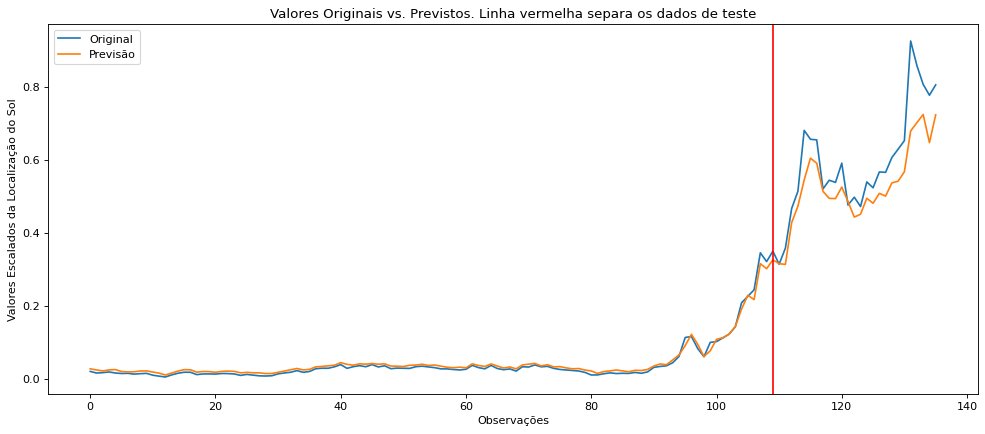

In [8]:
# Plot the result
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Original', 'Previsão'])
    plt.xlabel('Observações')
    plt.ylabel('Valores Escalados da Localização do Sol')
    plt.title('Valores Originais vs. Previstos. Linha vermelha separa os dados de teste')
plot_result(trainY, testY, train_predict, test_predict)

## RESPOSTA 1: Os valores de RMSE encontrados monstram que o modelo tem um treinamento eficaz, porém o valor do RMSE de teste ter sido relativamente maior pode indicar um overfitting. O gráfico confirma isso mostrando que a partir da linha vermelha ( que separa os dados de treinamento dos de teste ) há uma separação maior das linhas azul e laranja.

## Experimente adicionar mais uma camada LSTM após a primeira (mesmo número de unidades ocultas do item anterior). Reporte o resultado da mesma forma que o item anterior e comente se houve melhora

In [12]:
def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(LSTM(hidden_units, input_shape=input_shape, return_sequences=True, activation=activation[0]))
    model.add(LSTM(hidden_units, input_shape=input_shape,
                   activation=activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model = create_RNN(hidden_units=50, dense_units=1, input_shape=(time_steps,1),
                   activation=['tanh', 'tanh'])
model.fit(trainX, trainY, validation_data=(testX, testY), epochs=20, batch_size=1, verbose=2)

Epoch 1/20
109/109 - 3s - 26ms/step - loss: 5.5949e-04 - val_loss: 0.0103
Epoch 2/20
109/109 - 1s - 12ms/step - loss: 4.9669e-04 - val_loss: 0.0169
Epoch 3/20
109/109 - 1s - 8ms/step - loss: 1.6010e-04 - val_loss: 0.0040
Epoch 4/20
109/109 - 1s - 5ms/step - loss: 3.1519e-04 - val_loss: 0.0029
Epoch 5/20
109/109 - 1s - 5ms/step - loss: 1.8872e-04 - val_loss: 0.0060
Epoch 6/20
109/109 - 0s - 5ms/step - loss: 7.6148e-05 - val_loss: 0.0032
Epoch 7/20
109/109 - 0s - 4ms/step - loss: 1.3202e-04 - val_loss: 0.0045
Epoch 8/20
109/109 - 0s - 4ms/step - loss: 9.3224e-05 - val_loss: 0.0051
Epoch 9/20
109/109 - 0s - 4ms/step - loss: 4.7418e-05 - val_loss: 0.0085
Epoch 10/20
109/109 - 1s - 5ms/step - loss: 1.0198e-04 - val_loss: 0.0318
Epoch 11/20
109/109 - 1s - 6ms/step - loss: 3.0340e-04 - val_loss: 0.0234
Epoch 12/20
109/109 - 0s - 5ms/step - loss: 1.5562e-04 - val_loss: 0.0032
Epoch 13/20
109/109 - 1s - 6ms/step - loss: 1.2845e-04 - val_loss: 0.0037
Epoch 14/20
109/109 - 0s - 5ms/step - loss: 1

In [13]:
# Fazendo os previsões
train_predict = model.predict(trainX)
test_predict = model.predict(testX)
# Mean square error
print_error(trainY, testY, train_predict, test_predict)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Raíz do Erro Médio Quadrático para Treino: 0.008
Raíz do Erro Médio Quadrático para Teste: 0.067


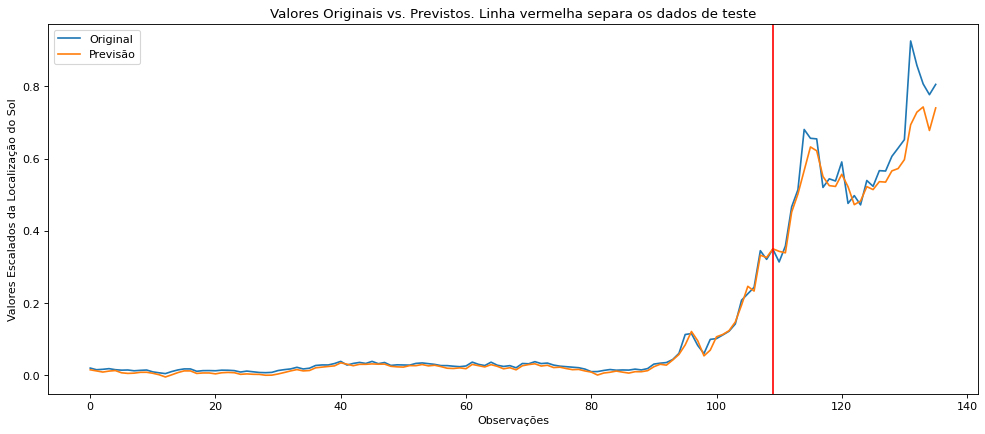

In [14]:
plot_result(trainY, testY, train_predict, test_predict)

## RESPOSTA 2: Após adicionar mais uma camada LSTM, foi possível perceber uma melhora no modelo, já que a diferença entre o RMSE de treino e de teste diminuiu em relação ao primeiro modelo treinado com apenas uma camada.

## Adicione um Dropout de 20% após cada camada LSTM e reporte se houve melhora.

In [17]:
def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(LSTM(hidden_units, input_shape=input_shape, return_sequences=True, activation=activation[0]))
    model.add(Dropout(0.2))
    model.add(LSTM(hidden_units, input_shape=input_shape,
                   activation=activation[0]))
    model.add(Dropout(0.2))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model = create_RNN(hidden_units=50, dense_units=1, input_shape=(time_steps,1),
                   activation=['tanh', 'tanh'])
model.fit(trainX, trainY, validation_data=(testX, testY), epochs=20, batch_size=1, verbose=2)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


109/109 - 2s - 21ms/step - loss: 0.0017 - val_loss: 0.0069
Epoch 2/20
109/109 - 1s - 5ms/step - loss: 2.1554e-04 - val_loss: 0.0076
Epoch 3/20
109/109 - 1s - 6ms/step - loss: 7.3956e-04 - val_loss: 0.0364
Epoch 4/20
109/109 - 1s - 6ms/step - loss: 4.5431e-04 - val_loss: 0.0134
Epoch 5/20
109/109 - 1s - 5ms/step - loss: 2.2993e-04 - val_loss: 0.0149
Epoch 6/20
109/109 - 1s - 5ms/step - loss: 2.3124e-04 - val_loss: 0.0078
Epoch 7/20
109/109 - 1s - 6ms/step - loss: 1.6737e-04 - val_loss: 0.0040
Epoch 8/20
109/109 - 1s - 5ms/step - loss: 4.0297e-04 - val_loss: 0.0043
Epoch 9/20
109/109 - 1s - 5ms/step - loss: 2.2436e-04 - val_loss: 0.0111
Epoch 10/20
109/109 - 1s - 9ms/step - loss: 1.6699e-04 - val_loss: 0.0056
Epoch 11/20
109/109 - 1s - 8ms/step - loss: 2.0444e-04 - val_loss: 0.0274
Epoch 12/20
109/109 - 1s - 8ms/step - loss: 2.1181e-04 - val_loss: 0.0032
Epoch 13/20
109/109 - 1s - 6ms/step - loss: 1.4933e-04 - val_loss: 0.0065
Epoch 14/20
109/109 - 1s - 5ms/step - loss: 1.1721e-04 - val_

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Raíz do Erro Médio Quadrático para Treino: 0.007
Raíz do Erro Médio Quadrático para Teste: 0.057


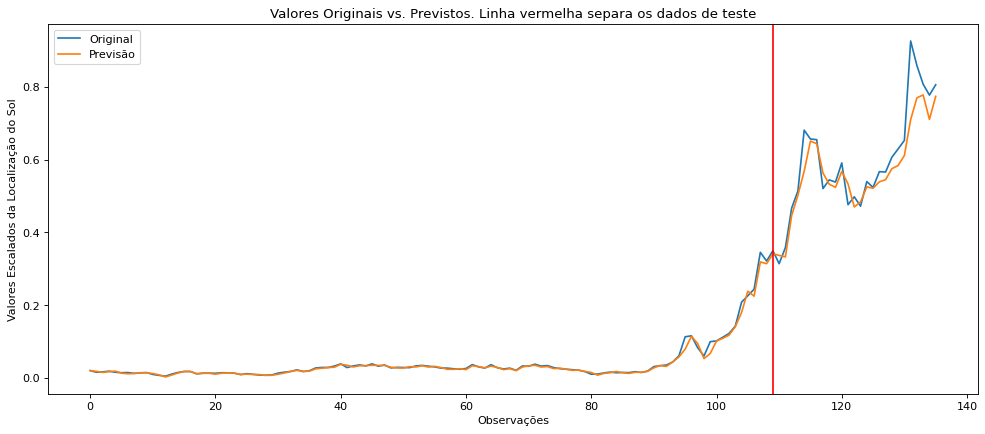

In [18]:
# Fazendo os previsões
train_predict = model.predict(trainX)
test_predict = model.predict(testX)
# Mean square error
print_error(trainY, testY, train_predict, test_predict)
# Plotando os resultados
plot_result(trainY, testY, train_predict, test_predict)

## RESPOSTA 3: A adição de um Dropout de 20% após cada camada LSTM resultou em uma melhora no desempenho do modelo. O RMSE diminuiu tanto para os dados de treinamento quanto para os dados de teste, indicando que o modelo está sjustando aos dados de treinamento, mas também generalizando melhor para os dados de teste.

## Modifique o modelo para que ele tenha 4 blocos LSTM (50 unidades ocultas) + Dropout (20 %) antes da camada Dense. Reporte os resultados deste último modelo e compare com os demais

In [22]:
def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(LSTM(hidden_units, input_shape=input_shape, return_sequences=True, activation=activation[0]))
    model.add(LSTM(hidden_units, input_shape=input_shape, return_sequences=True,
                   activation=activation[0]))
    model.add(LSTM(hidden_units, input_shape=input_shape, return_sequences=True,
                   activation=activation[0]))
    model.add(LSTM(hidden_units, input_shape=input_shape,
                   activation=activation[0]))
    model.add(Dropout(0.2))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model = create_RNN(hidden_units=50, dense_units=1, input_shape=(time_steps,1),
                   activation=['tanh', 'tanh'])
model.fit(trainX, trainY, validation_data=(testX, testY), epochs=20, batch_size=1, verbose=2)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


109/109 - 4s - 41ms/step - loss: 0.0016 - val_loss: 0.1866
Epoch 2/20
109/109 - 1s - 7ms/step - loss: 0.0011 - val_loss: 0.0069
Epoch 3/20
109/109 - 1s - 12ms/step - loss: 6.8535e-04 - val_loss: 0.0112
Epoch 4/20
109/109 - 1s - 11ms/step - loss: 7.3382e-04 - val_loss: 0.0182
Epoch 5/20
109/109 - 1s - 7ms/step - loss: 2.7053e-04 - val_loss: 0.0398
Epoch 6/20
109/109 - 1s - 7ms/step - loss: 5.7654e-04 - val_loss: 0.0626
Epoch 7/20
109/109 - 1s - 10ms/step - loss: 0.0015 - val_loss: 0.0292
Epoch 8/20
109/109 - 1s - 10ms/step - loss: 1.5817e-04 - val_loss: 0.0224
Epoch 9/20
109/109 - 1s - 7ms/step - loss: 1.9500e-04 - val_loss: 0.0276
Epoch 10/20
109/109 - 1s - 11ms/step - loss: 7.1014e-04 - val_loss: 0.0248
Epoch 11/20
109/109 - 1s - 7ms/step - loss: 4.4827e-04 - val_loss: 0.0262
Epoch 12/20
109/109 - 1s - 11ms/step - loss: 3.0613e-04 - val_loss: 0.0087
Epoch 13/20
109/109 - 1s - 11ms/step - loss: 3.6123e-04 - val_loss: 0.0548
Epoch 14/20
109/109 - 1s - 9ms/step - loss: 2.7829e-04 - val_l

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Raíz do Erro Médio Quadrático para Treino: 0.010
Raíz do Erro Médio Quadrático para Teste: 0.090


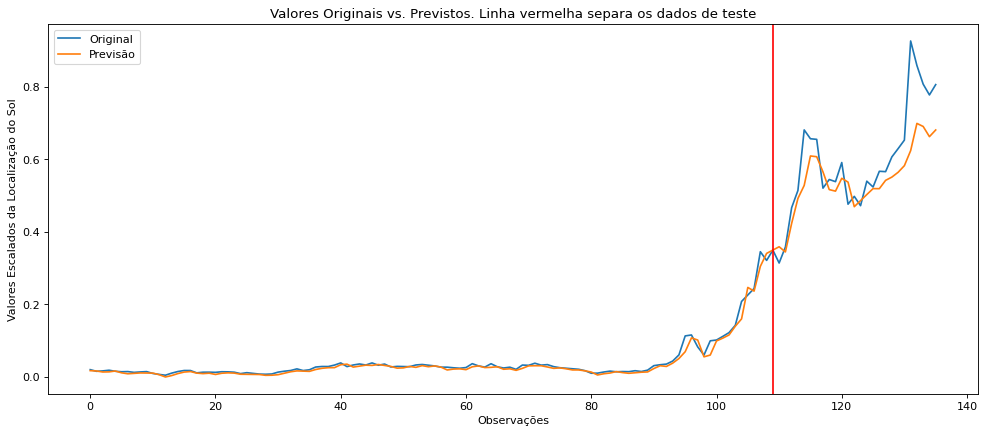

In [24]:
# Fazendo os previsões
train_predict = model.predict(trainX)
test_predict = model.predict(testX)
# Mean square error
print_error(trainY, testY, train_predict, test_predict)
# Plotando os resultados
plot_result(trainY, testY, train_predict, test_predict)

## RESPOSTA 4 : Houve uma piora em relação aos outros modelos treinados mostrando um leve sobreajuste